/Users/parkercarrus/miniforge3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
3993/3993 ━━━━━━━━━━━━━━━━━━━━ 144s 35ms/step - loss: 0.0316 - val_loss: 0.0038 - learning_rate: 3.0000e-04
Epoch 2/15
3993/3993 ━━━━━━━━━━━━━━━━━━━━ 139s 35ms/step - loss: 0.0074 - val_loss: 0.0020 - learning_rate: 3.0000e-04
Epoch 3/15
3993/3993 ━━━━━━━━━━━━━━━━━━━━ 135s 34ms/step - loss: 0.0047 - val_loss: 0.0013 - learning_rate: 3.0000e-04
Epoch 4/15
3993/3993 ━━━━━━━━━━━━━━━━━━━━ 133s 33ms/step - loss: 0.0039 - val_loss: 0.0012 - learning_rate: 3.0000e-04
Epoch 5/15
3993/3993 ━━━━━━━━━━━━━━━━━━━━ 133s 33ms/step - loss: 0.0036 - val_loss: 0.0013 - learning_rate: 3.0000e-04
Epoch 6/15
3993/3993 ━━━━━━━━━━━━━━━━━━━━ 134s 34ms/step - loss: 0.0035 - val_loss: 0.0015 - learning_rate: 3.0000e-04
Epoch 7/15
3993/3993 ━━━━━━━━━━━━━━━━━━━━ 141s 35ms/step - loss: 0.0034 - val_loss: 0.0013 - learning_rate: 3.0000e-04
Epoch 8/15
3993/3993 ━━━━━━━━━━━━━━━━━━━━ 141s 35ms/step - loss: 0.0034 - val_loss: 0.0011 - learning_rate: 3.0000e-04
Epoch 9/15
3993/3993 ━━━━━━━━━━━━━━━━━━━━ 166s 4

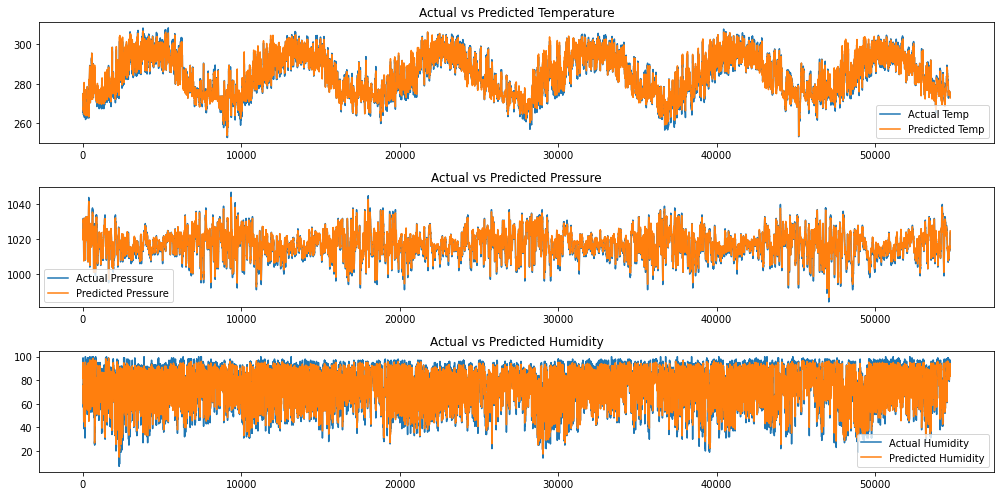

1711/1711 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.0012
Test Loss: 0.0009781400440260768


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Load data into pandas
data = pd.read_csv('/Users/parkercarrus/Desktop/Weather/LSTM2/Test Models/lstm_dataset.csv')
X = data[['time_sin', 'time_cos', 'year_day_sin', 'year_day_cos', 'temp', 'pressure', 'humidity']]
y = data[['temp', 'pressure', 'humidity']]

# Normalize all features and targets
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Create sequences
def create_sequences(X, y, sequence_length):
    Xs, ys = [], []
    for i in range(len(X) - sequence_length):
        Xs.append(X[i:(i + sequence_length)])  # Extract the sequence of features
        ys.append(y[i + sequence_length])  # Get the values for the next hour
    return np.array(Xs), np.array(ys)

sequence_length = 24
X_seq, y_seq = create_sequences(X_scaled, y_scaled, sequence_length)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.3, shuffle=False)

# Convert to TensorFlow dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Batch data
train_data = train_data.batch(32).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

# Build the model with specified architecture
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(sequence_length, X.shape[1])),  # LSTM layer with 100 units
    Dropout(0.3),  # Dropout for regularization
    LSTM(50, return_sequences=False),  # LSTM layer with 50 units
    Dropout(0.3),  # Dropout for regularization
    Dense(50, activation='relu'),  # Dense layer with 50 units
    Dropout(0.3),  # Dropout for regularization
    Dense(3)  # Output layer with three units for temperature, pressure, and humidity
])

# Compile the model with specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(train_data, epochs=15, validation_data=test_data, callbacks=[early_stopping, reduce_lr])

# Save the model using the recommended format
model.save('all_values_2.keras')

print("Training complete and model saved to 'all_values_2.keras'.")

# Make predictions on the test set
predictions = model.predict(test_data)

# Inverse transform the predictions and actual values
predictions_original_scale = scaler_y.inverse_transform(predictions)
y_test_original_scale = scaler_y.inverse_transform(y_test)

# Compare predictions to actual values (only the first few sequences for brevity)
comparison = pd.DataFrame({
    'Actual_Temp': y_test_original_scale[:, 0],
    'Predicted_Temp': predictions_original_scale[:, 0],
    'Actual_Pressure': y_test_original_scale[:, 1],
    'Predicted_Pressure': predictions_original_scale[:, 1],
    'Actual_Humidity': y_test_original_scale[:, 2],
    'Predicted_Humidity': predictions_original_scale[:, 2]
})

# Display the comparison DataFrame
print(comparison.head())

# Plot the actual vs predicted values for temperature, pressure, and humidity
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)
plt.plot(comparison['Actual_Temp'], label='Actual Temp')
plt.plot(comparison['Predicted_Temp'], label='Predicted Temp')
plt.legend()
plt.title('Actual vs Predicted Temperature')

plt.subplot(3, 1, 2)
plt.plot(comparison['Actual_Pressure'], label='Actual Pressure')
plt.plot(comparison['Predicted_Pressure'], label='Predicted Pressure')
plt.legend()
plt.title('Actual vs Predicted Pressure')

plt.subplot(3, 1, 3)
plt.plot(comparison['Actual_Humidity'], label='Actual Humidity')
plt.plot(comparison['Predicted_Humidity'], label='Predicted Humidity')
plt.legend()
plt.title('Actual vs Predicted Humidity')

plt.tight_layout()
plt.show()

# Evaluate the model
test_loss = model.evaluate(test_data)
print(f"Test Loss: {test_loss}")
